Sketch of the ‘story’ 
Before getting to the main point of the tutorial we should say:
Example things of what you can do with text processing - use nltk
Tokenizing text to sentences / words
Filtering stopwords
Stemming,Lemmatization, synonyms using WordNet
Create a corpora
POS tagging
And many others but we need to move forward
How the CORE API look like
Register for an API key
Focus on article retrieval function
Briefly go over the other functionalites (repository search, journal search)
 
And now the real tutorial can start:
Get articles of repository X
Choose a medium sized but high profile repository 
Data should be pre-loaded in pickles or .csv
Process a single article out of the bunch:
Simple stats (length, number of pages, size in disk, number of words, number of authors, …)
Show the challenge of extracting the email address of authors (in case of {name1,name2,...}@domain)
Process all the list of articles, come up with a list: 
articles -> author email -> domain -> affiliation
Visualise collaboration network of this repository


In [4]:
from urllib2 import urlopen
from urllib import urlencode
from urllib import quote_plus
from urllib import quote
# import urllib.parse
import json
import pprint

class CoreApiClient:

    def __init__(self, endpoint, api_key):
        self.endpoint = endpoint
        self.api_key = api_key
        #defaults
        self.pagesize = 100
        self.page = 1

    def parse_response(self, decoded):
        res = []
        for item in decoded['data']:
            doi = None
            if 'identifiers' in item:
                for identifier in item['identifiers']:
                    if identifier and identifier.startswith('doi:'):
                        doi = identifier
                        break
            res.append([item['title'], doi])
        return res

    def request_url(self, url):
        response = urlopen(url)
        html = response.read()
        return html

    def get_method_query_request_url(self,method,query,fullText,page):
        if (fullText):
            fullText = 'true'
        else:
            fullText = 'false'
        params = {
            'apiKey':self.api_key,
            'page':page,
            'pageSize':self.pagesize,
            'fulltext':fullText
        }
        return self.endpoint + method + '/' + quote_plus(query) + '?' + urlencode(params)

    def get_up_to_20_pages_of_query(self,method,query,fulltext):
        url = self.get_method_query_request_url(method,query,fulltext,1)
        all_articles=[]
        resp = self.request_url(url)
        result = json.loads(resp.decode('utf-8'))
        all_articles.append(result)
        if (result['totalHits']>100):
            numOfPages = int(result['totalHits']/self.pagesize)  #rounds down
            if (numOfPages>20):
                numOfPages=20
            for i in range(2,numOfPages):
                url = self.get_method_query_request_url(method,query,False,i)
                print(url)
                resp =self.request_url(url)
                all_articles.append(json.loads(resp.decode('utf-8')))
        return all_articles
    
    def get_repository_articles_fulltext_as_dict(self,repository_id):
        return ""
    
    def get_search_repository_request_url(self,repoQuery,page=1,pageSize=10):
        params={
            'apiKey':self.api_key,
            'page':page,
            'pageSize':pageSize
        }
        return self.endpoint + "/repositories/search/"+quote_plus(repoQuery)+'?'+urlencode(params)
    
    def search_repository_ids_by_name(self,repoName):
        discoverRepoUrl = self.get_search_repository_request_url(repoName)
        resp = self.request_url(discoverRepoUrl)
        result = json.loads(resp.decode('utf-8'))
        for item in result['data']:
            if 'name' in item:
                name = item['name']
            if 'id' in item:
                id = item['id']
            repos[id]=name
        return repos
    
    def get_count_articles_of_repository_url(self,repoId,withFullText):
        ft = 'false'
        if(withFullText):
            ft = 'true'
                
        params = {
            'apiKey':self.api_key,
            'fulltext':ft
        }    
        return self.endpoint + "/articles/search/repositories.id:"+repoId+'?'+urlencode(params)
    
    def count_articles_of_repository(self,repoId,withFullText=False):
        countArticlesOfRepoUrl = self.get_count_articles_of_repository_url(repoId,withFullText)
        print(countArticlesOfRepoUrl)
        resp = self.request_url(countArticlesOfRepoUrl)
        result = json.loads(resp.decode('utf-8'))
        return result['totalHits']
    
    def get_url_of_download_articles_of_repository(self,repoId,fullText,page,pageSize):
        params={
            'apiKey':self.api_key,
            'page':page,
            'pageSize':pageSize,
            'fulltext':fullText
               }
        return self.endpoint + "/articles/search/repositories.id:"+str(repoId)+'?'+urlencode(params)
    
    def download_articles_of_repository(self, repoId, fulltext=True, page=1, pageSize=100):
        url = self.get_url_of_download_articles_of_repository(repoId,fulltext,page,pageSize)
        all_articles=[]
        resp = self.request_url(url)
        result = json.loads(resp.decode('utf-8'))
        if (result['totalHits']>100):
            numOfPages = int(result['totalHits']/self.pagesize)  #rounds down
            if (numOfPages>5):
                numOfPages=5
            for i in range(2,numOfPages):
                url = self.get_url_of_download_articles_of_repository(repoId,fulltext,page,pageSize)
                print(url)
                resp =self.request_url(url)
                all_articles.append(json.loads(resp.decode('utf-8')))
        return all_articles
    
    def get_core_article_by_id(self,core_id,fulltext=False):
        ft='false'
        if (fulltext):
            ft='true'
        params={
            'apiKey':self.api_key,
            'fulltext':ft
        }
        url = self.endpoint + '/articles/get/'+str(core_id)+'?'+urlencode(params)
        print(url)
        resp = self.request_url(url)
        result = json.loads(resp.decode('utf-8'))
        if (result['data']):
            return result['data']
        else:
            return ""
        return ""
    
    def get_core_article_by_doi(self,doi,fulltext=False):
        ft='false'
        if (fulltext):
            ft='true'
        query = "\""+doi+"\""
        params={
            'apiKey':self.api_key,
            'fulltext':ft
        }
        url = self.endpoint + '/articles/search/doi:'+quote(query)+'?'+urlencode(params)
        resp = self.request_url(url)
        result = json.loads(resp.decode('utf-8'))
        if (result['totalHits']>=1):
            return result['data'][0]
        else:
            return ""
        

In [5]:
'''
Initialise parameters
'''
# init 
endpoint = 'https://core.ac.uk/api-v2'

'''
********************************************
Add your own api key below
'''
api_key =""
# or get it from a config file
file = open("api_key.secret","r") 
api_key=file.read()
'''
********************************************
'''
'''
Create your api object
'''
api = CoreApiClient(endpoint,api_key)

In [6]:
'''
Fetch an article by DOI
'''

doi="10.1016/j.nuclphysb.2015.11.012"
print(api.get_core_article_by_doi(doi,True))

{u'fullText': u'a\nr\nX\ni\nv\n:\n1\n0\n0\n7\n.\n1\n7\n7\n0\nv\n1\n \n \n[\nh\ne\np\n-\nt\nh\n]\n \n \n1\n1\n \nJ\nu\nl\n \n2\n0\n1\n0\nPreprint typeset in JHEP style - HYPER VERSION LPT ENS-10/25\nFinite Size Spectrum of SU(N) Principal Chiral Field\nfrom Discrete Hirota Dynamics\nVladimir Kazakov\u2217 and S\xb4 ebastien Leurent\nEcole Normale Superieure, LPT, 75231 Paris CEDEX-5, France &\nl\u2019Universit\xb4 e Paris-VI, Paris, France;\nE-mail: Vladimir.Kazakov\u2022ens.fr, Sebastien.Leurent\u2022ens.fr\nAbstract: Using recently proposed method of discrete Hirota dynamics for integrable\n(1+1)D quantum \ufb01eld theories on a \ufb01nite space circle of length L we derive and test\nnumerically a \ufb01nite system of nonlinear integral equations for the exact spectrum of energies\nof SU(N) \xd7 SU(N) principal chiral \ufb01eld model as functions of mL, where m is the mass\nscale. We propose a determinant solution of the underlying Y-system, or Hirota equation,\nin terms of determinan

In [7]:
doi="10.1016/j.nuclphysb.2015.11.111111111"
print(api.get_core_article_by_doi(doi))

In [8]:
'''
Fetch an article by core ID
'''
id=42
#just metadata
api.get_core_article_by_id(id)

https://core.ac.uk/api-v2/articles/get/42?fulltext=false&apiKey=20hIsS1F5j4D2C2iXrg4Wxf7VTp4Xt1j


{u'authors': [u'Bell, Simon', u'Christina, Ann'],
 u'contributors': [],
 u'datePublished': u'2006-02',
 u'description': u'This paper sets out some observations arising from on-going research into the use of systemic methods in the planning of complex projects within the National Health Service (NHS) in Staffordshire and Shropshire in the UK. This brief paper sets out the main reasons for the application of systemic approaches, the nature of the methodologies put in place and some of the outcomes and reflections of those involved in the various workshops. Whilst not attempting to be definitive in our conclusions, the authors believe that the results of the application of systemic methods by Health and Care professionals show a range of strengths going forward',
 u'fulltextIdentifier': u'https://core.ac.uk/download/pdf/42.pdf',
 u'id': u'42',
 u'identifiers': [u'oai:open.ac.uk.OAI2:108', None],
 u'language': {u'code': u'en', u'id': 9, u'name': u'English'},
 u'oai': u'oai:open.ac.uk.OAI2:

In [9]:
#with full text
api.get_core_article_by_id(id,True)

https://core.ac.uk/api-v2/articles/get/42?fulltext=true&apiKey=20hIsS1F5j4D2C2iXrg4Wxf7VTp4Xt1j


{u'authors': [u'Bell, Simon', u'Christina, Ann'],
 u'contributors': [],
 u'datePublished': u'2006-02',
 u'description': u'This paper sets out some observations arising from on-going research into the use of systemic methods in the planning of complex projects within the National Health Service (NHS) in Staffordshire and Shropshire in the UK. This brief paper sets out the main reasons for the application of systemic approaches, the nature of the methodologies put in place and some of the outcomes and reflections of those involved in the various workshops. Whilst not attempting to be definitive in our conclusions, the authors believe that the results of the application of systemic methods by Health and Care professionals show a range of strengths going forward',
 u'fullText': u'Open Research Online\nThe Open University\u2019s repository of research publications\nand other research outputs\nApplying Systemic Project Management Approaches\nfor the UK National Health Service\nJournal Articl

In [15]:
import nltk

In [16]:
'''
In case you don;t have nltk - uncomment and run
'''
# !pip3 install nltk
# import nltk

'\nIn case you don;t have nltk - uncomment and run\n'

In [17]:
from nltk.probability import FreqDist
from nltk.corpus import treebank
'''
in case any of the above complains, you need to download the corresponding corpora by executing:
nltk.download()
'''

'\nin case any of the above complains, you need to download the corresponding corpora by executing:\nnltk.download()\n'

In [18]:
articleText = api.get_core_article_by_id(42,True)['fullText']
articleText

https://core.ac.uk/api-v2/articles/get/42?fulltext=true&apiKey=20hIsS1F5j4D2C2iXrg4Wxf7VTp4Xt1j


u'Open Research Online\nThe Open University\u2019s repository of research publications\nand other research outputs\nApplying Systemic Project Management Approaches\nfor the UK National Health Service\nJournal Article\nHow to cite:\nBell, Simon and Christina, Ann (2006). Applying Systemic Project Management Approaches for the\nUK National Health Service. Systemic Practice and Action Research, 19(1), pp. 27\u201343.\nFor guidance on citations see FAQs.\nc\xa9 [not recorded]\nVersion: [not recorded]\nLink(s) to article on publisher\u2019s website:\nhttp://dx.doi.org/doi:10.1007/s11213-005-9002-4\nCopyright and Moral Rights for the articles on this site are retained by the individual authors and/or other copy-\nright owners. For more information on Open Research Online\u2019s data policy on reuse of materials please consult\nthe policies page.\noro.open.ac.uk\n 1\nApplying Systemic Project Management Approaches for the \nUK National Health Service1 \n \nDr. Simon Bell Ann Christina \nOpen 

## Sentence segmentation

In [19]:
'''
Let's split the text into sentences:
'''
sentences = nltk.sent_tokenize(articleText)
sentences

[u'Open Research Online\nThe Open University\u2019s repository of research publications\nand other research outputs\nApplying Systemic Project Management Approaches\nfor the UK National Health Service\nJournal Article\nHow to cite:\nBell, Simon and Christina, Ann (2006).',
 u'Applying Systemic Project Management Approaches for the\nUK National Health Service.',
 u'Systemic Practice and Action Research, 19(1), pp.',
 u'27\u201343.',
 u'For guidance on citations see FAQs.',
 u'c\xa9 [not recorded]\nVersion: [not recorded]\nLink(s) to article on publisher\u2019s website:\nhttp://dx.doi.org/doi:10.1007/s11213-005-9002-4\nCopyright and Moral Rights for the articles on this site are retained by the individual authors and/or other copy-\nright owners.',
 u'For more information on Open Research Online\u2019s data policy on reuse of materials please consult\nthe policies page.',
 u'oro.open.ac.uk\n 1\nApplying Systemic Project Management Approaches for the \nUK National Health Service1 \n \nDr.

In [20]:
import pprint
pprint.pprint(sentences)

[u'Open Research Online\nThe Open University\u2019s repository of research publications\nand other research outputs\nApplying Systemic Project Management Approaches\nfor the UK National Health Service\nJournal Article\nHow to cite:\nBell, Simon and Christina, Ann (2006).',
 u'Applying Systemic Project Management Approaches for the\nUK National Health Service.',
 u'Systemic Practice and Action Research, 19(1), pp.',
 u'27\u201343.',
 u'For guidance on citations see FAQs.',
 u'c\xa9 [not recorded]\nVersion: [not recorded]\nLink(s) to article on publisher\u2019s website:\nhttp://dx.doi.org/doi:10.1007/s11213-005-9002-4\nCopyright and Moral Rights for the articles on this site are retained by the individual authors and/or other copy-\nright owners.',
 u'For more information on Open Research Online\u2019s data policy on reuse of materials please consult\nthe policies page.',
 u'oro.open.ac.uk\n 1\nApplying Systemic Project Management Approaches for the \nUK National Health Service1 \n \nDr.

In [21]:
'''
Couldn't we just split(".") ??
'''
wrong_sentences = articleText.split(".")
len(wrong_sentences)

396

In [22]:
len(sentences)

327

In [23]:
'''
Aparently not, e.g. see this sentence
'''
sentences[5]

u'c\xa9 [not recorded]\nVersion: [not recorded]\nLink(s) to article on publisher\u2019s website:\nhttp://dx.doi.org/doi:10.1007/s11213-005-9002-4\nCopyright and Moral Rights for the articles on this site are retained by the individual authors and/or other copy-\nright owners.'

In [24]:
sentences[5].split(".")

[u'c\xa9 [not recorded]\nVersion: [not recorded]\nLink(s) to article on publisher\u2019s website:\nhttp://dx',
 u'doi',
 u'org/doi:10',
 u'1007/s11213-005-9002-4\nCopyright and Moral Rights for the articles on this site are retained by the individual authors and/or other copy-\nright owners',
 u'']

It incorrectly breaks down to more than one (5) sentences.

Let's break further to tokens (words):

In [25]:
tokenized_sentences = [nltk.word_tokenize(sentence) for sentence in sentences]
tokenized_sentences[1:100]

[[u'Applying',
  u'Systemic',
  u'Project',
  u'Management',
  u'Approaches',
  u'for',
  u'the',
  u'UK',
  u'National',
  u'Health',
  u'Service',
  u'.'],
 [u'Systemic',
  u'Practice',
  u'and',
  u'Action',
  u'Research',
  u',',
  u'19',
  u'(',
  u'1',
  u')',
  u',',
  u'pp',
  u'.'],
 [u'27\u201343', u'.'],
 [u'For', u'guidance', u'on', u'citations', u'see', u'FAQs', u'.'],
 [u'c\xa9',
  u'[',
  u'not',
  u'recorded',
  u']',
  u'Version',
  u':',
  u'[',
  u'not',
  u'recorded',
  u']',
  u'Link',
  u'(',
  u's',
  u')',
  u'to',
  u'article',
  u'on',
  u'publisher\u2019s',
  u'website',
  u':',
  u'http',
  u':',
  u'//dx.doi.org/doi:10.1007/s11213-005-9002-4',
  u'Copyright',
  u'and',
  u'Moral',
  u'Rights',
  u'for',
  u'the',
  u'articles',
  u'on',
  u'this',
  u'site',
  u'are',
  u'retained',
  u'by',
  u'the',
  u'individual',
  u'authors',
  u'and/or',
  u'other',
  u'copy-',
  u'right',
  u'owners',
  u'.'],
 [u'For',
  u'more',
  u'information',
  u'on',
  u'Open

## Part of speech tagging (POS tagging):

In [18]:
pos_tagged_0 = nltk.pos_tag(tokenized_sentences[0])
pprint.pprint(sentences[0])
pprint.pprint(tokenized_sentences[0])
pprint.pprint(pos_tagged_0)

u'Open Research Online\nThe Open University\u2019s repository of research publications\nand other research outputs\nApplying Systemic Project Management Approaches\nfor the UK National Health Service\nJournal Article\nHow to cite:\nBell, Simon and Christina, Ann (2006).'
[u'Open',
 u'Research',
 u'Online',
 u'The',
 u'Open',
 u'University\u2019s',
 u'repository',
 u'of',
 u'research',
 u'publications',
 u'and',
 u'other',
 u'research',
 u'outputs',
 u'Applying',
 u'Systemic',
 u'Project',
 u'Management',
 u'Approaches',
 u'for',
 u'the',
 u'UK',
 u'National',
 u'Health',
 u'Service',
 u'Journal',
 u'Article',
 u'How',
 u'to',
 u'cite',
 u':',
 u'Bell',
 u',',
 u'Simon',
 u'and',
 u'Christina',
 u',',
 u'Ann',
 u'(',
 u'2006',
 u')',
 u'.']
[(u'Open', 'JJ'),
 (u'Research', 'NNP'),
 (u'Online', 'NNP'),
 (u'The', 'DT'),
 (u'Open', 'NNP'),
 (u'University\u2019s', 'NNP'),
 (u'repository', 'NN'),
 (u'of', 'IN'),
 (u'research', 'NN'),
 (u'publications', 'NNS'),
 (u'and', 'CC'),
 (u'other', 'J

What does the label mean next to each token ?
1. NN -> noun (plural)
2. NNP -> noun (singular)
3. VB -> Verb
4. CC -> conjuction
5. ,,,,


A full list of each label can be found here: http://www.comp.leeds.ac.uk/amalgam/tagsets/upenn.html

## NER Named Entity Recognition

In [19]:
parse_tree = nltk.ne_chunk(nltk.tag.pos_tag(sentences[1].split()), binary=True)
named_entities = []

for t in parse_tree.subtrees():
    if t.label() == 'NE':
#         named_entities.append(t)
        named_entities.append(list(t))  # if you want to save a list of tagged words instead of a tree

pprint.pprint(named_entities)

[[(u'Systemic', 'NNP'), (u'Project', 'NNP')],
 [(u'UK', 'NNP'), (u'National', 'NNP'), (u'Health', 'NNP')]]


In [20]:
## DBPedia spotlight
## TextRazor 
## for more "semantic" labels

In [23]:
## DBPedia spotlight:
'''
Get the article abstract
'''
articleAbstract=api.get_core_article_by_id(42,True)['description']
articleAbstract

https://core.ac.uk/api-v2/articles/get/42?fulltext=true&apiKey=20hIsS1F5j4D2C2iXrg4Wxf7VTp4Xt1j


u'This paper sets out some observations arising from on-going research into the use of systemic methods in the planning of complex projects within the National Health Service (NHS) in Staffordshire and Shropshire in the UK. This brief paper sets out the main reasons for the application of systemic approaches, the nature of the methodologies put in place and some of the outcomes and reflections of those involved in the various workshops. Whilst not attempting to be definitive in our conclusions, the authors believe that the results of the application of systemic methods by Health and Care professionals show a range of strengths going forward'

In [24]:
url = "http://model.dbpedia-spotlight.org/en/annotate?text="+quote_plus(articleAbstract)
response = urlopen(url)
r_text = response.read()
r_text

'<?xml version="1.0" encoding="utf-8"?>\n<Annotation text="This paper sets out some observations arising from on-going research into the use of systemic methods in the planning of complex projects within the National Health Service (NHS) in Staffordshire and Shropshire in the UK. This brief paper sets out the main reasons for the application of systemic approaches, the nature of the methodologies put in place and some of the outcomes and reflections of those involved in the various workshops. Whilst not attempting to be definitive in our conclusions, the authors believe that the results of the application of systemic methods by Health and Care professionals show a range of strengths going forward" confidence="0.5" support="0" types="" sparql="" policy="whitelist">\n<Resources>\n<Resource URI="http://dbpedia.org/resource/National_Health_Service" support="2159" types="" surfaceForm="National Health Service" offset="149" similarityScore="0.9758748241862786" percentageOfSecondRank="0.02472

In [31]:
'''
The same as above but printing XML nice'''

import lxml.etree as etree

x = etree.fromstring(r_text)
print(etree.tostring(x, pretty_print = True))


<Annotation text="This paper sets out some observations arising from on-going research into the use of systemic methods in the planning of complex projects within the National Health Service (NHS) in Staffordshire and Shropshire in the UK. This brief paper sets out the main reasons for the application of systemic approaches, the nature of the methodologies put in place and some of the outcomes and reflections of those involved in the various workshops. Whilst not attempting to be definitive in our conclusions, the authors believe that the results of the application of systemic methods by Health and Care professionals show a range of strengths going forward" confidence="0.5" support="0" types="" sparql="" policy="whitelist">
<Resources>
<Resource URI="http://dbpedia.org/resource/National_Health_Service" support="2159" types="" surfaceForm="National Health Service" offset="149" similarityScore="0.9758748241862786" percentageOfSecondRank="0.024721451522763886"/>
<Resource URI="http://dbpe

## Stemming

In [100]:
from nltk.stem import PorterStemmer

In [101]:
stemmer = PorterStemmer()

In [104]:
stemmer.stem("Management")


u'Manag'

In [105]:
stemmer.stem("Manager")

u'Manag'

In [106]:
stemmer.stem("Managerial")

u'Manageri'

In [109]:
for token in tokenized_sentences[0]:
    pprint.pprint(token+' '+stemmer.stem(token))

u'Open Open'
u'Research Research'
u'Online Onlin'
u'The The'
u'Open Open'
u'University\u2019s University\u2019'
u'repository repositori'
u'of of'
u'research research'
u'publications public'
u'and and'
u'other other'
u'research research'
u'outputs output'
u'Applying Appli'
u'Systemic System'
u'Project Project'
u'Management Manag'
u'Approaches Approach'
u'for for'
u'the the'
u'UK UK'
u'National Nation'
u'Health Health'
u'Service Servic'
u'Journal Journal'
u'Article Articl'
u'How How'
u'to to'
u'cite cite'
u': :'
u'Bell Bell'
u', ,'
u'Simon Simon'
u'and and'
u'Christina Christina'
u', ,'
u'Ann Ann'
u'( ('
u'2006 2006'
u') )'
u'. .'


What if I don't do English?


In [110]:
from nltk.stem import SnowballStemmer
SnowballStemmer.languages

(u'danish',
 u'dutch',
 u'english',
 u'finnish',
 u'french',
 u'german',
 u'hungarian',
 u'italian',
 u'norwegian',
 u'porter',
 u'portuguese',
 u'romanian',
 u'russian',
 u'spanish',
 u'swedish')

## Lemmatization

Like stemming but not exactly - more like synonym replacement

In [116]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
lemmatizer.lemmatize('paper')

'paper'

In [118]:
lemmatizer.lemmatize('buses')

u'bus'

In [120]:
for token in tokenized_sentences[0]:
    pprint.pprint(token+' '+lemmatizer.lemmatize(token))

u'Open Open'
u'Research Research'
u'Online Online'
u'The The'
u'Open Open'
u'University\u2019s University\u2019s'
u'repository repository'
u'of of'
u'research research'
u'publications publication'
u'and and'
u'other other'
u'research research'
u'outputs output'
u'Applying Applying'
u'Systemic Systemic'
u'Project Project'
u'Management Management'
u'Approaches Approaches'
u'for for'
u'the the'
u'UK UK'
u'National National'
u'Health Health'
u'Service Service'
u'Journal Journal'
u'Article Article'
u'How How'
u'to to'
u'cite cite'
u': :'
u'Bell Bell'
u', ,'
u'Simon Simon'
u'and and'
u'Christina Christina'
u', ,'
u'Ann Ann'
u'( ('
u'2006 2006'
u') )'
u'. .'


Pretty much the same, or maybe not ??

In [123]:
'''printing all the words that lemma is different than the word'''
for tokenized_sentence in tokenized_sentences:
    for token in tokenized_sentence:
        ltoken = lemmatizer.lemmatize(token)
        stoken=stemmer.stem(token)
        if (ltoken!=token):
            pprint.pprint(token+' '+ltoken)


u'Online Onlin Online'
u'University\u2019s University\u2019 University\u2019s'
u'repository repositori repository'
u'publications public publication'
u'Applying Appli Applying'
u'Systemic System Systemic'
u'Management Manag Management'
u'Approaches Approach Approaches'
u'National Nation National'
u'Service Servic Service'
u'Article Articl Article'
u'Applying Appli Applying'
u'Systemic System Systemic'
u'Management Manag Management'
u'Approaches Approach Approaches'
u'National Nation National'
u'Service Servic Service'
u'Systemic System Systemic'
u'Practice Practic Practice'
u'guidance guidanc guidance'
u'citations citat citation'
u'FAQs FAQ FAQs'
u'recorded record recorded'
u'recorded record recorded'
u'article articl article'
u'publisher\u2019s publisher\u2019 publisher\u2019s'
u'website websit website'
u'Rights Right Rights'
u'articles articl article'
u'this thi this'
u'retained retain retained'
u'individual individu individual'
u'information inform information'
u'Online\u2019s Onlin

So is like stemming, or maybe not

In [124]:
'''Printing all the words that stemming is different than the lemma'''
for tokenized_sentence in tokenized_sentences:
    for token in tokenized_sentence:
        ltoken = lemmatizer.lemmatize(token)
        stoken=stemmer.stem(token)
        if (ltoken!=stoken):
            pprint.pprint(token+' '+stoken+' '+ltoken)

u'Online Onlin Online'
u'University\u2019s University\u2019 University\u2019s'
u'repository repositori repository'
u'publications public publication'
u'Applying Appli Applying'
u'Systemic System Systemic'
u'Management Manag Management'
u'Approaches Approach Approaches'
u'National Nation National'
u'Service Servic Service'
u'Article Articl Article'
u'Applying Appli Applying'
u'Systemic System Systemic'
u'Management Manag Management'
u'Approaches Approach Approaches'
u'National Nation National'
u'Service Servic Service'
u'Systemic System Systemic'
u'Practice Practic Practice'
u'guidance guidanc guidance'
u'citations citat citation'
u'FAQs FAQ FAQs'
u'recorded record recorded'
u'recorded record recorded'
u'article articl article'
u'publisher\u2019s publisher\u2019 publisher\u2019s'
u'website websit website'
u'Rights Right Rights'
u'articles articl article'
u'this thi this'
u'retained retain retained'
u'individual individu individual'
u'information inform information'
u'Online\u2019s Onlin

## Spelling correction

In [125]:
#can be done woth import enchant but omitting for now

## Text classification

# Small text mining exercises

In [32]:
## Get some data

In [35]:
repoId=1
'''
Use page size 50 
-
store as pickle every 200 articles (4 pages)
in the end you will have in the /data folder files like: *
all_articles_on1_1.pkl
all_articles_on1_2.pkl
all_articles_on1_3.pkl
...


*/data is in .gitignore 
'''
import os
import pickle
if not os.path.exists('./data'):
    os.makedirs('./data')
all_articles=[]
for i in range(1,40):
    url = api.get_url_of_download_articles_of_repository(repoId,True,i,50)# 40* 50 = 2000 (maximum articles per repo)
    response = urlopen(url)
    resp = response.read()
    result = json.loads(resp.decode('utf-8'))
    all_articles.append(result)
    if (i%4==0):
        pickle.dump(all_articles,open('data/all_articles_on'+str(repoId)+'_'+str(i/4)+'.pkl','wb'),pickle.HIGHEST_PROTOCOL)
        all_articles=[]

In [126]:
## Important words

In [45]:
### With frequency (tag clouds)
!pip install pytagcloud
!pip install pygame
from pytagcloud import create_tag_image, make_tags
from pytagcloud.lang.counter import get_tag_counts

In [2]:
!pip install wordcloud


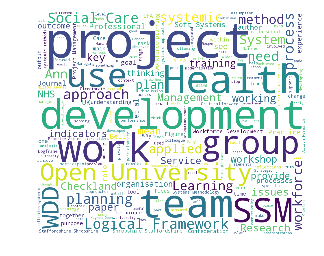

In [13]:
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

#Convert all the required text into a single string here 
#and store them in word_string

#you can specify fonts, stopwords, background color and other options

wordcloud = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='white',
                          width=1200,
                          height=1000
                         ).generate(articleText)


plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [14]:
wordcloud

In [128]:
### With term frequency (tf-idf)

In [28]:
!pip install gensim



    100% |████████████████████████████████| 6.4MB 84kB/s 
    100% |████████████████████████████████| 16.2MB 35kB/s 
    100% |████████████████████████████████| 4.6MB 135kB/s 
  Running setup.py bdist_wheel for smart-open ... - \ done
  Stored in directory: /Users/lucasanastasiou/Library/Caches/pip/wheels/b0/81/ad/856aade935fceaab491a800ec4de58edb8642afa4c4ba91a00
  Running setup.py bdist_wheel for bz2file ... - \ done
  Stored in directory: /Users/lucasanastasiou/Library/Caches/pip/wheels/31/9c/20/996d65ca104cbca940b1b053299b68459391c01c774d073126
Successfully built smart-open bz2file
  Found existing installation: numpy 1.11.2
    Uninstalling numpy-1.11.2:
      Successfully uninstalled numpy-1.11.2
  Found existing installation: scipy 0.18.1
    Uninstalling scipy-0.18.1:
      Successfully uninstalled scipy-0.18.1


Using Theano backend.


RuntimeError: module compiled against API version 0xb but this version of numpy is 0xa

In [34]:
from gensim import corpora, models, similarities
dictionary = corpora.Dictionary(tokenized_sentences)
dictionary.save('./article.dict')

In [36]:
raw_corpus = [dictionary.doc2bow(s) for s in tokenized_sentences]

In [38]:
corpora.MmCorpus.serialize('/corpus.mm', raw_corpus)

In [39]:
tfidf = models.TfidfModel(raw_corpus)

In [42]:
corpus_tfidf = tfidf[raw_corpus]

In [43]:
corpus_tfidf

In [45]:
index = similarities.MatrixSimilarity(tfidf[raw_corpus])

In [46]:
# similarity matrix of all sentences in document
sims = index[corpus_tfidf]
sims

array([[  1.00000012e+00,   4.71046418e-01,   1.17217541e-01, ...,
          2.26836763e-02,   1.92092918e-02,   4.86873509e-03],
       [  4.71046418e-01,   1.00000000e+00,   9.34595093e-02, ...,
          3.31700380e-06,   2.46217223e-06,   2.22648237e-06],
       [  1.17217541e-01,   9.34595093e-02,   1.00000000e+00, ...,
          5.37379049e-02,   1.22127727e-01,   1.15340929e-02],
       ..., 
       [  2.26836763e-02,   3.31700380e-06,   5.37379012e-02, ...,
          1.00000000e+00,   8.02861899e-03,   7.26008508e-03],
       [  1.92092918e-02,   2.46217246e-06,   1.22127727e-01, ...,
          8.02861899e-03,   1.00000000e+00,   5.38907433e-03],
       [  4.86873509e-03,   2.22648237e-06,   1.15340929e-02, ...,
          7.26008508e-03,   5.38907433e-03,   1.00000000e+00]], dtype=float32)

In [47]:
len(tokenized_sentences)

327

In [49]:
len(sims)

327

In [51]:
print list(enumerate(sims))

[(0, array([  1.00000012e+00,   4.71046418e-01,   1.17217541e-01,
         2.31533954e-06,   1.15028115e-06,   3.52948979e-02,
         6.41927347e-02,   3.68825316e-01,   1.39048055e-01,
         2.71920878e-02,   2.90647577e-02,   7.60137215e-02,
         1.87396348e-01,   7.98291527e-03,   3.25058214e-02,
         4.62971181e-02,   3.09793688e-02,   2.00154837e-02,
         2.54441351e-02,   3.15568522e-02,   3.16010118e-02,
         2.08118707e-02,   1.97906885e-02,   2.20813397e-02,
         2.09440049e-02,   1.05200466e-02,   1.63223110e-02,
         8.54866356e-02,   1.60849746e-02,   4.86624278e-02,
         1.59421489e-02,   1.89921334e-02,   3.33384797e-02,
         2.61936821e-02,   2.47207675e-02,   2.74930503e-02,
         2.01391689e-02,   4.06284556e-02,   5.11965379e-02,
         6.26097433e-03,   6.23306679e-03,   3.23623582e-03,
         1.99698359e-02,   5.15156845e-03,   5.00702076e-02,
         3.19620296e-02,   9.51236530e-07,   7.42826238e-02,
         1.40865166

In [53]:
## find most similar sentence of a sentence,e.g. of 2nd sentence
print(sentences[1])


Applying Systemic Project Management Approaches for the
UK National Health Service.


In [66]:
import numpy as np
np.argsort(sims[1])

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        40,  39,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  60,  59,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  81,  80,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 122, 121, 120, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 142, 141,
       143, 144, 145, 146, 147, 148, 149, 150, 152, 151, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [76]:
print(sentences[0],sentences[12],sims[0][12])

(u'Open Research Online\nThe Open University\u2019s repository of research publications\nand other research outputs\nApplying Systemic Project Management Approaches\nfor the UK National Health Service\nJournal Article\nHow to cite:\nBell, Simon and Christina, Ann (2006).', u'Accepted for Systemic Practice and Action Research 2006, Vol.', 0.18739635)


In [ ]:
## Discovering collaboration networks of a repository

In [129]:
## External author-collaborators over time

In [ ]:
## Collaborators across universities

In [ ]:
## Combining important terms with external collaboration networks
### What are the topics that gets the most external authors ?